In [ ]:
from torchvision.datasets import CIFAR100
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.autograd import Variable
from torch.utils.data import DataLoader
import copy
from PIL import Image
import torch.optim as optim

## Dataset

In [ ]:
class Cifar100(CIFAR100):

    def __init__(self, root = 'Dataset', classes=range(10), train=True, transform=None, target_transform=None, download=True):

        super(Cifar100, self).__init__(root, train=train, transform=transform, target_transform=target_transform, download=download)

        # Select subset of classes 
        data = []
        targets = []

        print(classes)

        for i in range(len(self.data)):
            if self.targets[i] in classes:
                data.append(self.data[i])
                targets.append(self.targets[i])

        self.data = np.array(data)
        self.targets = targets


    def __getitem__(self, index):
        
        img, target = self.data[index], self.targets[index]
       
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return index, img, target

    def __len__(self):
        
        return len(self.data)

    def get_image_class(self, label):
        return self.data[np.array(self.targets) == label]

    def append(self, images, labels):
        self.data = np.concatenate((self.data, images), axis=0)
        self.targets = self.targets + labels

In [ ]:
train_dataset = Cifar100(classes=range(0, (1) * 10), train=True)
train_dataset = Cifar100(classes=range(1 * 10, (1 + 1) * 10), train=True)

100%|██████████| 169001437/169001437 [00:01<00:00, 102537444.30it/s]


Extracting Dataset/cifar-100-python.tar.gz to Dataset
range(0, 10)
Files already downloaded and verified
range(10, 20)


## Resnet implementation PyTorch

In [ ]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

In [ ]:
class BasicBlock(nn.Module):

    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        # In the ResNet architecture, downsampling is used to reduce the spatial dimensions of feature maps 
        # within the residual blocks. This downsampling is achieved through either the stride parameter in the 
        # convolutional layers or the presence of a downsampling branch in the form of a 1x1 convolutional layer in the Bottleneck blocks. 
        # Downsampling allows ResNet to capture hierarchical features at different scales and enables the network to learn representations of increasing 
        # complexity as the spatial dimensions decrease.
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [ ]:
class Bottleneck(nn.Module):
    expansion = 4
    #  This class represents a bottleneck residual block in ResNet. 
    # It is similar to the BasicBlock but includes an additional convolutional layer (conv3) and batch normalization (bn3). 
    # The Bottleneck block is used when the number of input and output channels differ. 
    # It reduces the dimensionality using a 1x1 convolution before the 3x3 convolution and then expands it back using another 1x1 convolution. 
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [ ]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=10):
        print(num_classes)
        self.inplanes = 16
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, layers[0])
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.fc = nn.Linear(64 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x, features = False):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        if features:
            x = x / x.norm()
        else:
            x = self.fc(x)

        return x

In [ ]:
def resnet32(pretrained=False, **kwargs):
    n = 5
    model = ResNet(BasicBlock, [n, n, n], **kwargs)
    return model

## FineTuning

In [ ]:
DEVICE = 'cuda'
NUM_CLASSES = 100
BATCH_SIZE = 128
CLASSES_BATCH =10
STEPDOWN_EPOCHS = [49, 63]
STEPDOWN_FACTOR = 5
LR = 2
MOMENTUM = 0.9
WEIGHT_DECAY = 0.00001
NUM_EPOCHS = 70

In [ ]:
parameters = {
    'name': 'Finetuning',
    'NUM_CLASSES': NUM_CLASSES,
    'BATCH_SIZE' : BATCH_SIZE,
    'CLASSES_BATCH' : CLASSES_BATCH,
    'STEPDOWN_EPOCHS' : STEPDOWN_EPOCHS,
    'STEPDOWN_FACTOR' : STEPDOWN_FACTOR,
    'LR' : LR,
    'MOMENTUM' : MOMENTUM,
    'WEIGHT_DECAY' : WEIGHT_DECAY,
    'NUM_EPOCHS' : NUM_EPOCHS
}

In [ ]:
#train function
def train(net, train_dataloader, test_dataloader, n_classes=100):

  criterion = nn.BCEWithLogitsLoss()
  parameters_to_optimize = net.parameters()
  optimizer = optim.SGD(parameters_to_optimize, lr=LR, weight_decay=WEIGHT_DECAY)

  train_accuracies = []
  train_losses = []
  test_accuracies = []
  test_losses = []
  best_net = []
  best_accuracy = 0

  net.to(DEVICE)

  for epoch in range(NUM_EPOCHS):

    if epoch in STEPDOWN_EPOCHS:
      for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr']/STEPDOWN_FACTOR

    running_loss = 0.0
    running_corrects_train = 0

    for index, inputs, labels in train_dataloader:
      inputs = inputs.to(DEVICE)
      labels = labels.to(DEVICE)
      
      labels_hot=torch.eye(n_classes,device=DEVICE)[labels]
      labels_hot = labels_hot.to(DEVICE)

      net.train(True)
      # zero the parameter gradients
      optimizer.zero_grad()
      # forward
      outputs = net(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels_hot)
      loss.backward()
      optimizer.step()

      # statistics
      running_loss += loss.item() * inputs.size(0)
      running_corrects_train += torch.sum(preds == labels.data).data.item()

    # Calculate average losses
    epoch_loss = running_loss / float(len(train_dataloader.dataset))
    # Calculate accuracy
    epoch_acc = running_corrects_train / float(len(train_dataloader.dataset))
    
    if epoch % 10 == 0 or epoch == (NUM_EPOCHS-1):
      print('Epoch {} Loss:{:.4f} Accuracy:{:.4f}'.format(epoch, epoch_loss, epoch_acc))
      for param_group in optimizer.param_groups:
        print('Learning rate:{}'.format(param_group['lr']))
      print('-'*30)

    epoch_test_accuracy, epoch_test_loss = test(net, test_dataloader)

    train_accuracies.append(epoch_acc)
    train_losses.append(epoch_loss)
    test_accuracies.append(epoch_test_accuracy)
    test_losses.append(epoch_test_loss)

    if epoch_test_accuracy > best_accuracy:
      best_accuracy = epoch_test_accuracy
      best_net = copy.deepcopy(net) 

  return best_net, train_accuracies, train_losses, test_accuracies, test_losses

In [ ]:
def test(net, test_dataloader, n_classes=100):
  criterion = nn.BCEWithLogitsLoss()

  net.to(DEVICE)
  net.train(False)

  running_loss = 0.0
  running_corrects = 0
  for index, images, labels in test_dataloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    labels_hot=torch.eye(n_classes,device=DEVICE)[labels]
    labels_hot = labels_hot.to(DEVICE)

    # Forward Pass
    outputs = net(images)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)
    loss = criterion(outputs, labels_hot)

    # statistics
    running_loss += loss.item() * images.size(0)
    running_corrects += torch.sum(preds == labels.data).data.item()

  # Calculate average losses
  epoch_loss = running_loss / float(len(test_dataloader.dataset))
  # Calculate Accuracy
  accuracy = running_corrects / float(len(test_dataloader.dataset))

  return accuracy, epoch_loss

In [ ]:
def incremental_learning():

  # Define transforms for training phase
  transform_train = transforms.Compose([
                                        transforms.RandomCrop(32, padding=4),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                       ])
  transform_test = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ])
  
  net = resnet32(num_classes=NUM_CLASSES)

  new_acc_train_list = []
  new_loss_train_list = []
  new_acc_test_list = []
  new_loss_test_list = []
  all_acc_list = []

  for i in range(int(NUM_CLASSES/CLASSES_BATCH)):

    print('-'*30)
    print(f'**** ITERATION {i+1} ****')
    print('-'*30)

    print('Loading the Datasets ...')
    print('-'*30)

    train_dataset = Cifar100(classes=range(i*10, (i + 1)*10), train=True, transform=transform_train)
    test_dataset = Cifar100(classes=range(i*10, (i + 1)*10), train=False, transform=transform_test)

    print('-'*30)
    print('Training ...')
    print('-'*30)

    # Prepare Dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=4)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=4)

    net, train_accuracies, train_losses, test_accuracies, test_losses = train(net, train_dataloader, test_dataloader)

    new_acc_train_list.append(train_accuracies)
    new_loss_train_list.append(train_losses)
    new_acc_test_list.append(test_accuracies)
    new_loss_test_list.append(test_losses)    
    
    print('Testing ...')
    print('-'*30)
    

    # Creating dataset for test on previous classes
    previous_classes = np.array([])

    all_classes_dataset = Cifar100(classes=range(0, (i + 1)*10), train=False, transform=transform_test)

    # Prepare Dataloader
    test_all_dataloader = DataLoader(all_classes_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=4)

    print('All classes')
    
    all_acc_list.append(test(net, test_all_dataloader))

    print('-'*30)

  return new_acc_train_list, new_loss_train_list, new_acc_test_list, new_loss_test_list, all_acc_list

In [ ]:
new_acc_train_list, new_loss_train_list, new_acc_test_list, new_loss_test_list, all_acc_list = incremental_learning()

100
100
------------------------------
**** ITERATION 1 ****
------------------------------
Loading the Datasets ...
------------------------------
Files already downloaded and verified
range(0, 10)
Files already downloaded and verified
range(0, 10)
------------------------------
Training ...
------------------------------
Epoch 0 Loss:0.0791 Accuracy:0.1124
Learning rate:2
------------------------------
Epoch 10 Loss:0.0241 Accuracy:0.4592
Learning rate:2
------------------------------
Epoch 20 Loss:0.0193 Accuracy:0.5854
Learning rate:2
------------------------------
Epoch 30 Loss:0.0164 Accuracy:0.6602
Learning rate:2
------------------------------
Epoch 40 Loss:0.0144 Accuracy:0.7024
Learning rate:2
------------------------------
Epoch 50 Loss:0.0113 Accuracy:0.7786
Learning rate:0.4
------------------------------
Epoch 60 Loss:0.0109 Accuracy:0.7842
Learning rate:0.4
------------------------------
Epoch 69 Loss:0.0102 Accuracy:0.8042
Learning rate:0.08
----------------------------

In [ ]:
def plot(new_acc_train, new_acc_test, new_loss_train, new_loss_test, all_acc, args):
    num_epochs = len(new_acc_train[0])
    x = np.linspace(1, num_epochs, num_epochs)

    for i, (acc_train, acc_test, loss_train, loss_test) in enumerate(zip(new_acc_train, new_acc_test, new_loss_train, new_loss_test)):

        title = 'Accuracy dataset # %d - BATCH_SIZE= %d LR= %f  EPOCHS= %d' \
                % (i + 1, args['BATCH_SIZE'], args['LR'], args['NUM_EPOCHS'])
        title2 = 'Loss dataset # %d - BATCH_SIZE= %d LR= %f  EPOCHS= %d' \
                 % (i + 1, args['BATCH_SIZE'], args['LR'], args['NUM_EPOCHS'])

        plt.plot(x, acc_train, color='mediumseagreen')
        plt.plot(x, acc_test, color='lightseagreen')
        plt.title(title)
        plt.xticks(np.arange(1, num_epochs, 4))
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(['Train accuracy', 'Test accuracy'], loc='best')
        plt.show()

        plt.plot(x, loss_train, color='mediumseagreen')
        plt.plot(x, loss_test, color='lightseagreen')
        plt.title(title2)
        plt.xticks(np.arange(1, num_epochs, 4))
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(['Train loss', 'Test loss'], loc='best')
        plt.show()

    plt.plot(all_acc, color='lightseagreen')
    plt.title('%s incremental learning accuracy' % (args['name']))
    plt.xticks(np.arange(1, len(all_acc), 1))
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.legend(['Test accuracy'], loc='best')
    plt.show()

    # csv_name = '%s - BATCH_SIZE= %d LR= %f  EPOCHS= %d' % (args['name'], args['BATCH_SIZE'], args['LR'], args['NUM_EPOCHS'])
    # pd.DataFrame(all_acc).to_csv('./Results/%s.csv' % csv_name)

    print('Accuracy last test', new_acc_test[-1])

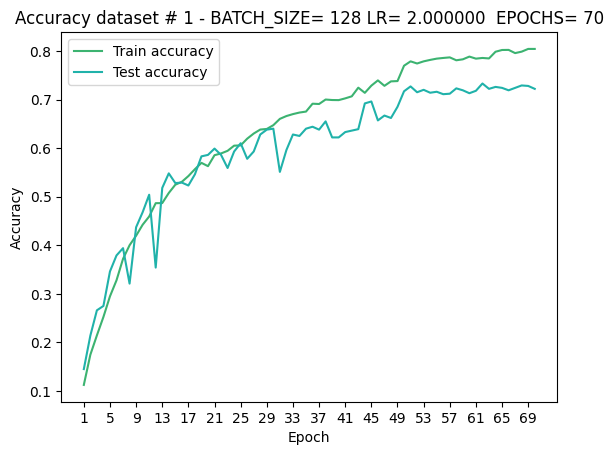

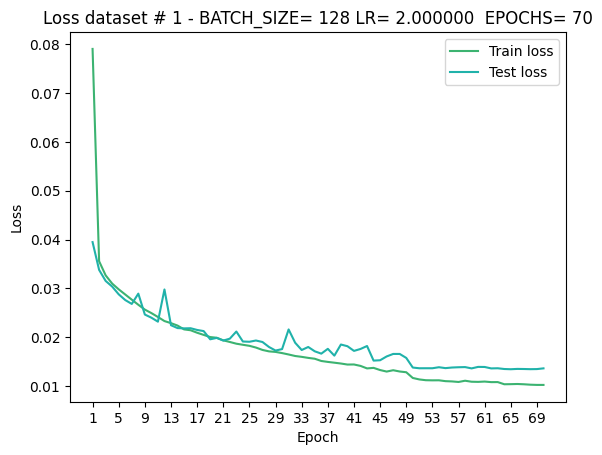

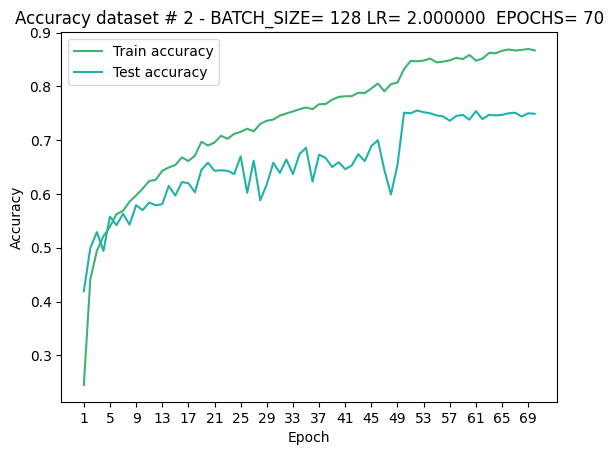

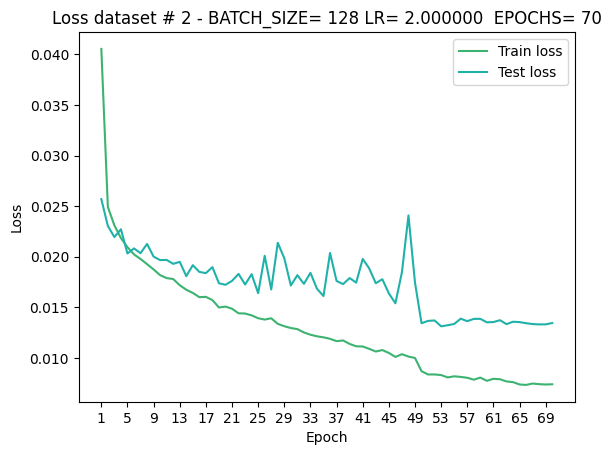

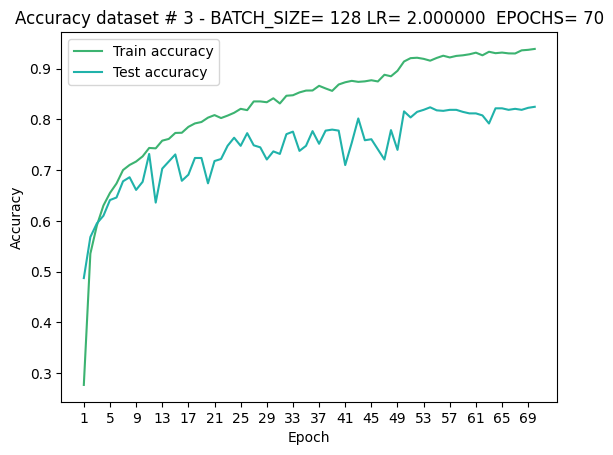

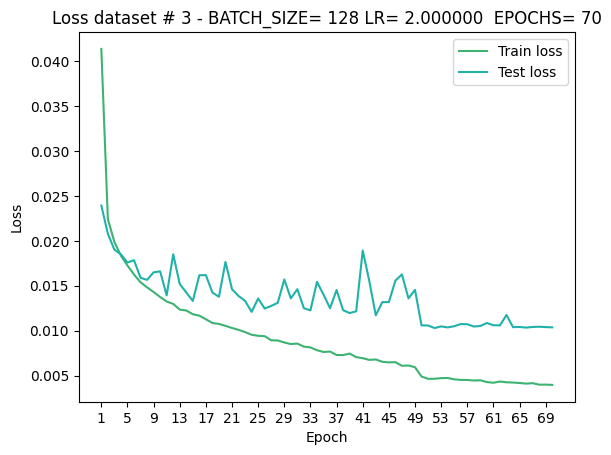

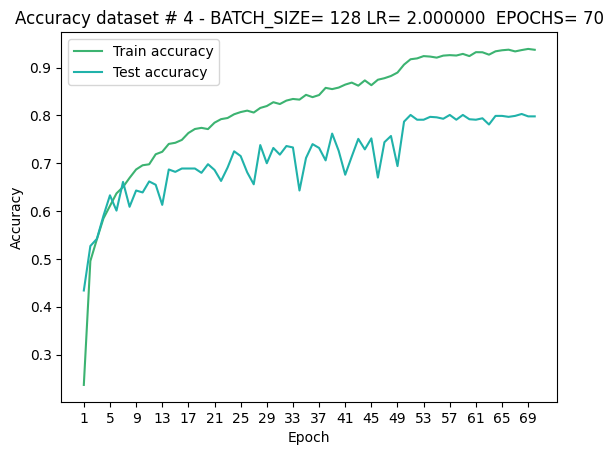

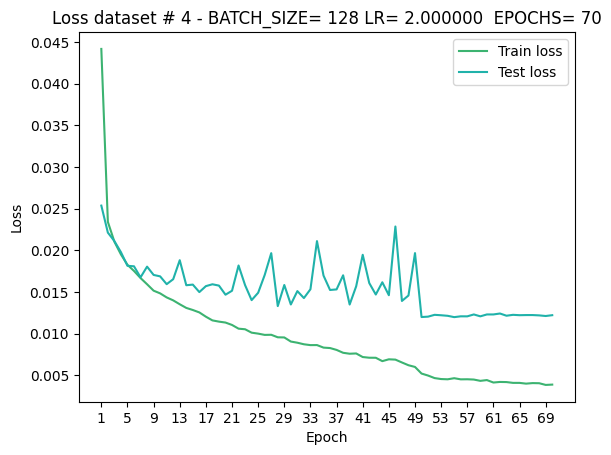

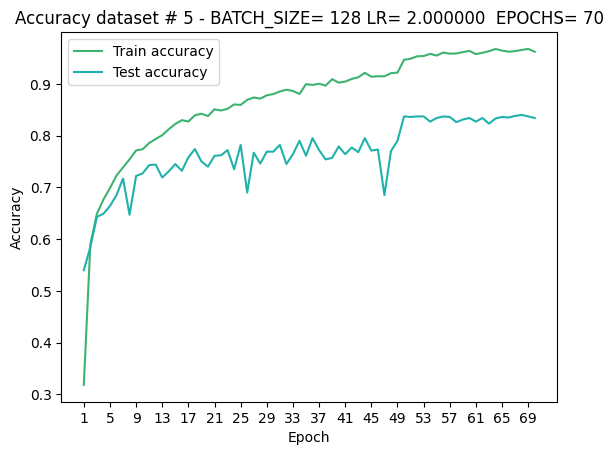

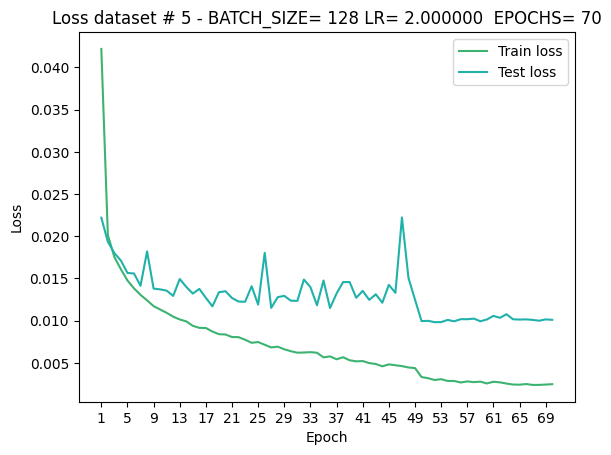

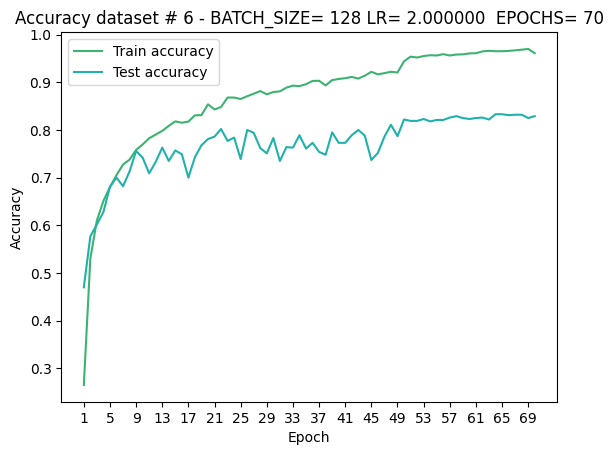

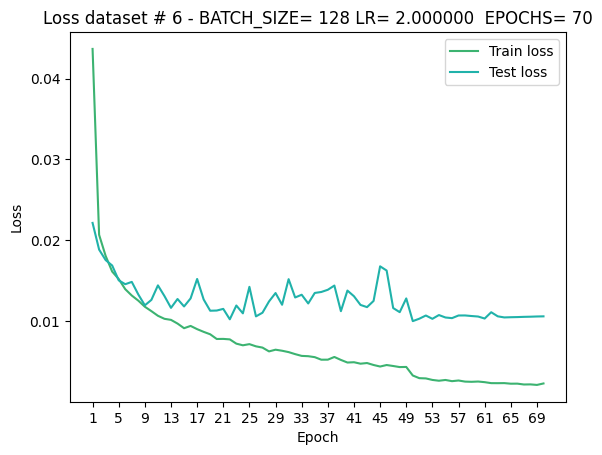

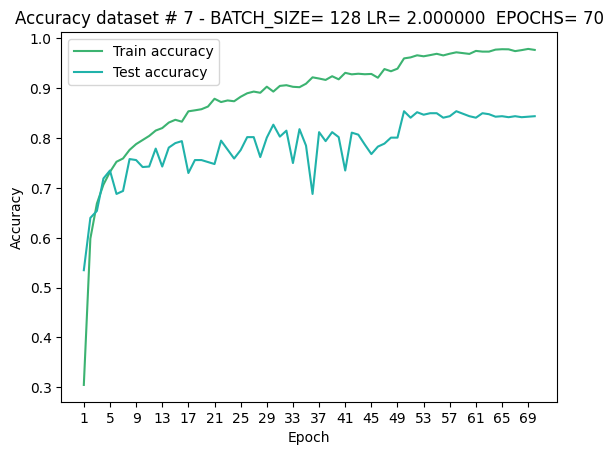

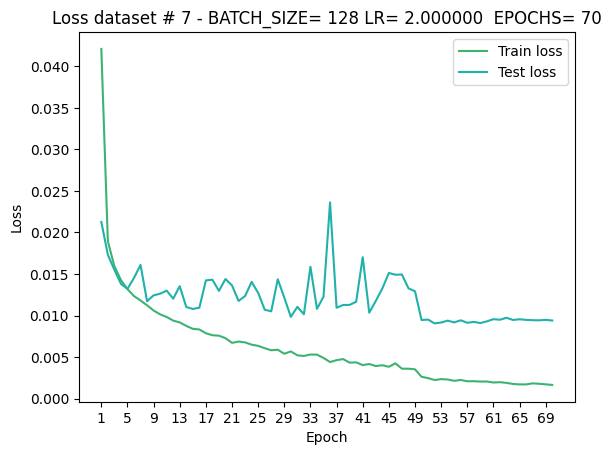

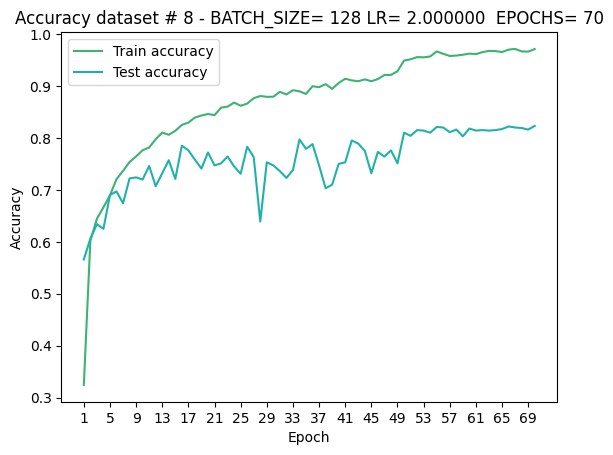

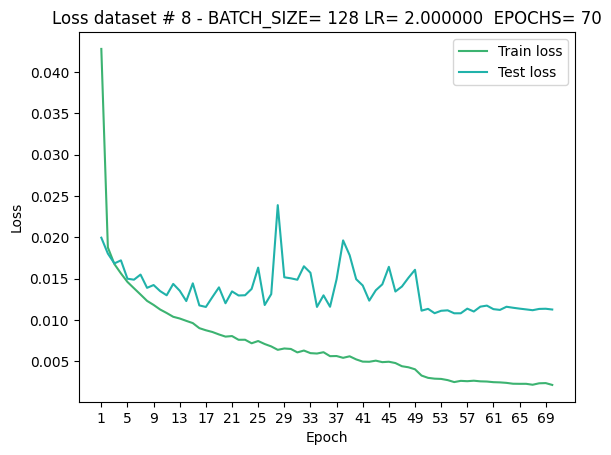

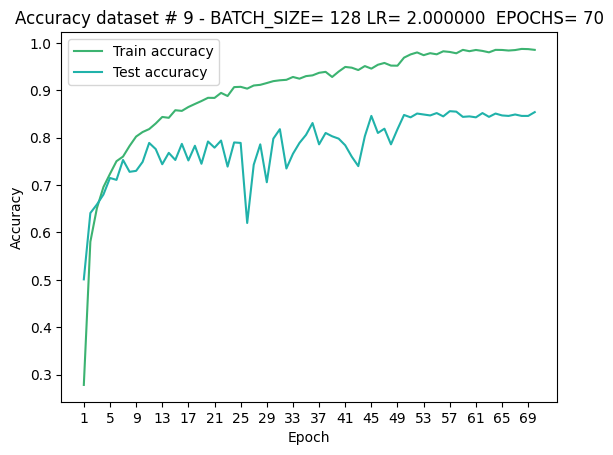

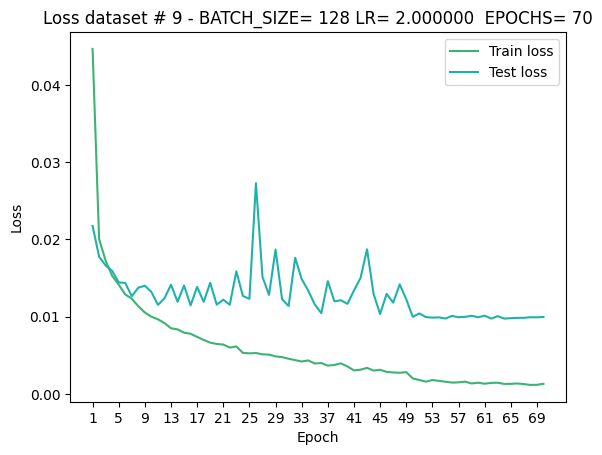

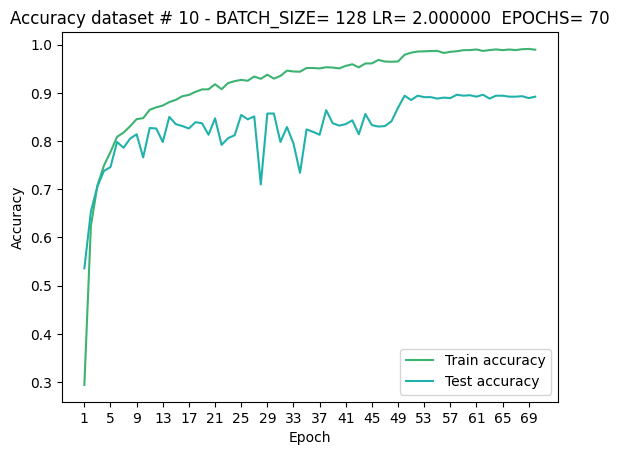

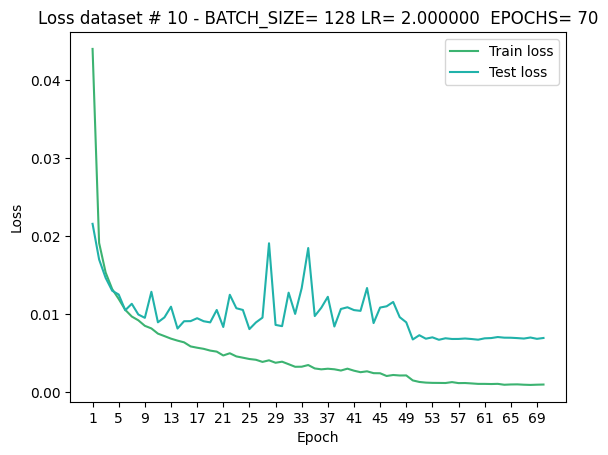

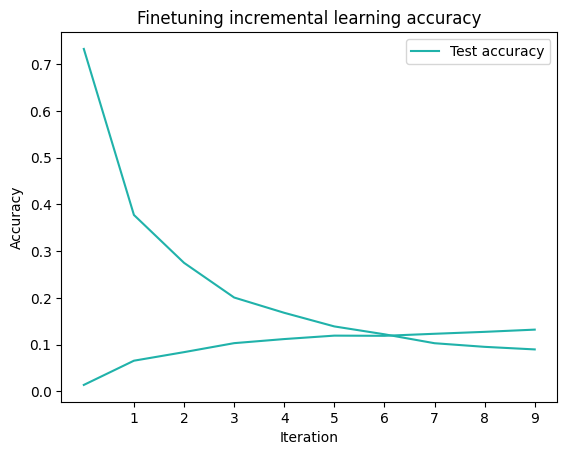

Accuracy last test [0.536, 0.654, 0.706, 0.738, 0.746, 0.798, 0.786, 0.805, 0.814, 0.766, 0.827, 0.826, 0.798, 0.85, 0.835, 0.831, 0.826, 0.839, 0.837, 0.813, 0.847, 0.792, 0.806, 0.812, 0.854, 0.845, 0.851, 0.71, 0.857, 0.857, 0.798, 0.829, 0.795, 0.734, 0.824, 0.819, 0.813, 0.864, 0.837, 0.832, 0.835, 0.843, 0.814, 0.856, 0.833, 0.83, 0.831, 0.841, 0.869, 0.894, 0.885, 0.894, 0.891, 0.891, 0.888, 0.89, 0.889, 0.896, 0.894, 0.895, 0.892, 0.896, 0.888, 0.894, 0.894, 0.892, 0.892, 0.893, 0.889, 0.892]


In [ ]:
plot(new_acc_train_list, new_acc_test_list, new_loss_train_list, new_loss_test_list, all_acc_list, parameters)

## Train & Test

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import transforms
from torch.autograd import Variable
from torch.utils.data import DataLoader
import copy

In [ ]:
# train function
def train(net, train_dataloader, test_dataloader, n_net):
    # criterion = nn.CrossEntropyLoss()
    criterion = nn.BCEWithLogitsLoss()

    parameters_to_optimize = net.parameters()
    optimizer = optim.SGD(parameters_to_optimize, lr=LR, weight_decay=WEIGHT_DECAY)

    train_accuracies = []
    train_losses = []
    test_accuracies = []
    test_losses = []
    best_net = []
    best_accuracy = 0

    net.to(DEVICE)

    for epoch in range(NUM_EPOCHS):

      # adjusting the learning rate throughout the training process.
  
        if epoch in STEPDOWN_EPOCHS:
            for param_group in optimizer.param_groups:
                param_group['lr'] = param_group['lr'] / STEPDOWN_FACTOR

        running_loss = 0.0
        running_corrects_train = 0

        for index, inputs, labels in train_dataloader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # incremental learning (removes the first datas)
            labels.data = labels.data - n_net * 10
            labels_hot = torch.eye(NUM_CLASSES,device=DEVICE)[labels]
            labels_hot = labels_hot.to(DEVICE)

            net.train(True)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward
            outputs = net(inputs)
            _, preds = torch.max(outputs, 1)

            loss = criterion(outputs, labels_hot)

            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects_train += torch.sum(preds == labels.data).data.item()

        # Calculate average losses
        epoch_loss = running_loss / float(len(train_dataloader.dataset))
        # Calculate accuracy
        epoch_acc = running_corrects_train / float(len(train_dataloader.dataset))

        if epoch % 10 == 0 or epoch == (NUM_EPOCHS - 1):
            print('Epoch {} Loss:{:.4f} Accuracy:{:.4f}'.format(epoch, epoch_loss, epoch_acc))
            for param_group in optimizer.param_groups:
                print('Learning rate:{}'.format(param_group['lr']))
            print('-' * 30)

        epoch_test_accuracy, epoch_test_loss = test(net, test_dataloader, n_net)

        train_accuracies.append(epoch_acc)
        train_losses.append(epoch_loss)
        test_accuracies.append(epoch_test_accuracy)
        test_losses.append(epoch_test_loss)

        if epoch_test_accuracy > best_accuracy:
            best_accuracy = epoch_test_accuracy
            best_net = copy.deepcopy(net)

    return best_net, train_accuracies, train_losses, test_accuracies, test_losses

The test function is typically used during the training process to evaluate the performance of the model on a test dataset after each epoch or a certain number of iterations. It computes the loss and accuracy of the model on the test dataset and returns these metrics. It is commonly used to monitor the progress of the model during training and make decisions such as early stopping or saving the best model.

In [ ]:
def test(net, test_dataloader, n_net):
    # criterion = nn.CrossEntropyLoss()
    criterion = nn.BCEWithLogitsLoss()

    net.to(DEVICE)
    net.train(False)

    running_loss = 0.0
    running_corrects = 0
    for index, images, labels in test_dataloader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # incremental learning (removes first datas)
        labels.data = labels.data - n_net * 10
        labels_hot = torch.eye(NUM_CLASSES,device=DEVICE)[labels]
        labels_hot = labels_hot.to(DEVICE)

        # Forward Pass
        outputs = net(images)

        # Get predictions
        _, preds = torch.max(outputs.data, 1)

        loss = criterion(outputs, labels_hot)

        # statistics
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate average losses
    epoch_loss = running_loss / float(len(test_dataloader.dataset))
    # Calculate Accuracy
    accuracy = running_corrects / float(len(test_dataloader.dataset))

    return accuracy, epoch_loss


In [ ]:
#  calucalte m-index
#  metric used to assess the diversity and quality of ranked lists or recommendation systems.
# A higher m-Index indicates a more diverse distribution of importance among the top-ranked items, while a lower m-Index suggests a more concentrated focus on the highest-ranked item.
def mIndexFunction(output):
    tot = 0
    idx = []
    output = output.cpu().detach().numpy()
    # print('output', output)
    for out in output:
        out.sort()
        out = out[::-1]
        # print('outreversed', out)

        # tot = 0
        # for i in range(3):#len(out)):
        #     if i == 0: tot = out[i]
        #     tot -= out[i] / float(i + 1)

        tot = 1
        for i in range(1, 3):
            tot -= out[i] ** 2 / (out[0] * i)

        idx.append(tot * out[1] / out[0])
        # print('tot', tot*(out[1])/out[0])
    return np.squeeze(idx)

In [ ]:
# TODO: Define a smart classifier
def classifier(outputs):
    _, preds = torch.max(outputs.data, 1)
    return preds

On the other hand, the final_test function is usually used after the training is completed to assess the final performance of the trained model on the test dataset. It performs a similar evaluation as the test function, computing the loss and accuracy, but it may not be called during the training loop. It is commonly used to report the final performance of the model and compare it with other models or baselines.



In [ ]:
# train function
def final_test(net, test_dataloader):
    criterion = nn.CrossEntropyLoss()
    running_loss = 0.0
    running_corrects = 0
    for index, images, labels in test_dataloader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        # lab = labels.to(DEVICE)

        # labels_hot = torch.eye(NUM_CLASSES * CLASSES_BATCH)[labels]
        # labels_hot = labels_hot.to(DEVICE)

        outputs = []
        loss = []
        idxs = []

        # TODO: change the 10
        # labels_hot = torch.eye(10)[labels]
        # labels_hot = labels_hot.to(DEVICE)
        for i, n in enumerate(net):
            n.to(DEVICE)
            n.train(False)

            # We compute the loss for each output in order to choose the nn
            # with the smallest loss value
            output = n(images)
            outputs.append(output)

            output = torch.softmax(output, 1)
            idxs.append(mIndexFunction(output))

            # loss.append(criterion(output, labels).item())

        best_net_index = np.asarray(idxs).argmax(axis=0)
        # best_net_index = np.asarray(loss).argmin(axis=0)
        preds = classifier(outputs[best_net_index])

        # TODO: overwrite the output with normalized values (for loss function)
        # TODO: Understand what s label and how to adapt to the nn forest
        # TODO: Then write a loss function

        # running_loss += loss[best_net_index] * images.size(0)
        running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate average losses
    epoch_loss = running_loss / float(len(test_dataloader.dataset))

    # Calculate Accuracy
    accuracy = running_corrects / float(len(test_dataloader.dataset))

    return accuracy, epoch_loss


In [ ]:
def incremental_learning():
    # Define transforms for training phase
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    net = []

    new_acc_train_list = []
    new_loss_train_list = []
    new_acc_test_list = []
    new_loss_test_list = []
    all_acc_list = []

    for i in range(CLASSES_BATCH):
        net.append(resnet32(num_classes=NUM_CLASSES))

        print('-' * 30)
        print(f'**** ITERATION {i + 1} ****')
        print('-' * 30)

        print('Loading the Datasets ...')
        print('-' * 30)

        train_dataset = Cifar100(classes=range(i * 10, (i + 1) * 10), train=True, transform=transform_train)
        test_dataset = Cifar100(classes=range(i * 10, (i + 1) * 10), train=False, transform=transform_test)

        print('-' * 30)
        print('Training ...')
        print('-' * 30)

        # Prepare Dataloaders
        train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=4)
        test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=4)

        net[i], train_accuracies, train_losses, test_accuracies, test_losses = train(net[i], train_dataloader,
                                                                                     test_dataloader, i)

        new_acc_train_list.append(train_accuracies)
        new_loss_train_list.append(train_losses)
        new_acc_test_list.append(test_accuracies)
        new_loss_test_list.append(test_losses)

        print('Testing ...')
        print('-' * 30)

        all_classes_dataset = Cifar100(classes=range(0, (i + 1) * 10), train=False, transform=transform_test)

        # Prepare Dataloader
        test_all_dataloader = DataLoader(all_classes_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                         drop_last=False, num_workers=4)

        print('All classes')

        all_acc_list.append(final_test(net, test_all_dataloader))

        print('-' * 30)

    return new_acc_train_list, new_loss_train_list, new_acc_test_list, new_loss_test_list, all_acc_list

In [ ]:
new_acc_train_list, new_loss_train_list, new_acc_test_list, new_loss_test_list, all_acc_list = incremental_learning()

------------------------------
**** ITERATION 1 ****
------------------------------
Loading the Datasets ...
------------------------------


100%|██████████| 169001437/169001437 [00:12<00:00, 13066259.52it/s]


Extracting Dataset/cifar-100-python.tar.gz to Dataset
Files already downloaded and verified
------------------------------
Training ...
------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0 Loss:0.1848 Accuracy:0.0764
Learning rate:2
------------------------------
Epoch 10 Loss:0.0293 Accuracy:0.2306
Learning rate:2
------------------------------
Epoch 20 Loss:0.0263 Accuracy:0.3192
Learning rate:2
------------------------------
Epoch 30 Loss:0.0240 Accuracy:0.3836
Learning rate:2
------------------------------
Epoch 40 Loss:0.0228 Accuracy:0.4082
Learning rate:2
------------------------------
Epoch 50 Loss:0.0214 Accuracy:0.4484
Learning rate:0.4
------------------------------
Epoch 60 Loss:0.0209 Accuracy:0.4602
Learning rate:0.4
------------------------------
Epoch 69 Loss:0.0207 Accuracy:0.4666
Learning rate:0.08
------------------------------
Testing ...
------------------------------
Files already downloaded and verified
All classes
------------------------------
------------------------------
**** ITERATION 2 ****
------------------------------
Loading the Datasets ...
------------------------------
Files already downloaded and verified
Files already downlo

In [ ]:
def plot(new_acc_train, new_acc_test, new_loss_train, new_loss_test, all_acc, args):
    num_epochs = len(new_acc_train[0])
    x = np.linspace(1, num_epochs, num_epochs)

    for i, (acc_train, acc_test, loss_train, loss_test) in enumerate(zip(new_acc_train, new_acc_test, new_loss_train, new_loss_test)):

        title = 'Accuracy dataset # %d - BATCH_SIZE= %d LR= %f  EPOCHS= %d' \
                % (i + 1, args['BATCH_SIZE'], args['LR'], args['NUM_EPOCHS'])
        title2 = 'Loss dataset # %d - BATCH_SIZE= %d LR= %f  EPOCHS= %d' \
                 % (i + 1, args['BATCH_SIZE'], args['LR'], args['NUM_EPOCHS'])

        plt.plot(x, acc_train, color='mediumseagreen')
        plt.plot(x, acc_test, color='lightseagreen')
        plt.title(title)
        plt.xticks(np.arange(1, num_epochs, 4))
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(['Train accuracy', 'Test accuracy'], loc='best')
        plt.show()

        plt.plot(x, loss_train, color='mediumseagreen')
        plt.plot(x, loss_test, color='lightseagreen')
        plt.title(title2)
        plt.xticks(np.arange(1, num_epochs, 4))
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(['Train loss', 'Test loss'], loc='best')
        plt.show()

    plt.plot(all_acc, color='lightseagreen')
    plt.title('%s incremental learning accuracy' % (args['name']))
    plt.xticks(np.arange(1, len(all_acc), 1))
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.legend(['Test accuracy'], loc='best')
    plt.show()

    # csv_name = '%s - BATCH_SIZE= %d LR= %f  EPOCHS= %d' % (args['name'], args['BATCH_SIZE'], args['LR'], args['NUM_EPOCHS'])
    # pd.DataFrame(all_acc).to_csv('./Results/%s.csv' % csv_name)

    print('Accuracy last test', new_acc_test[-1])

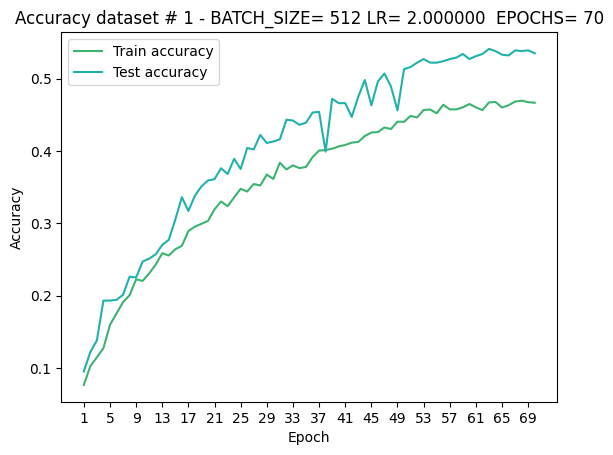

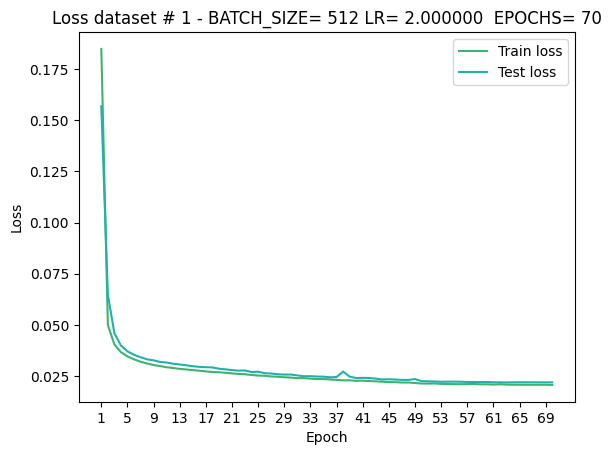

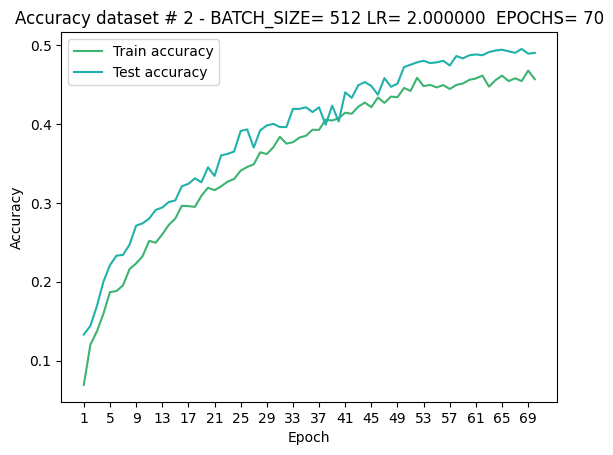

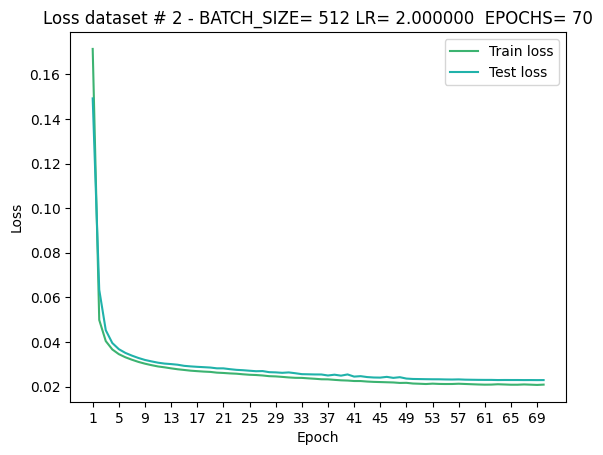

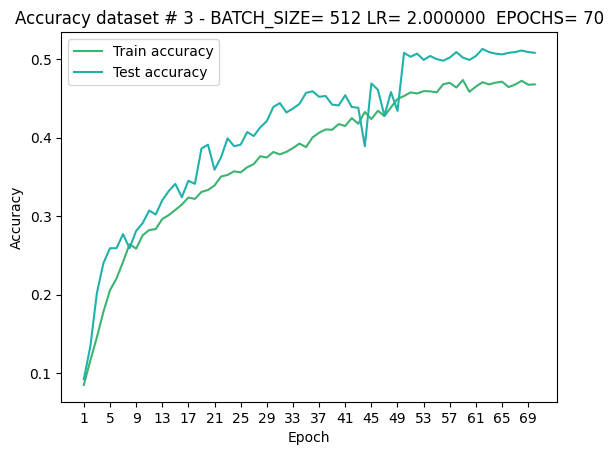

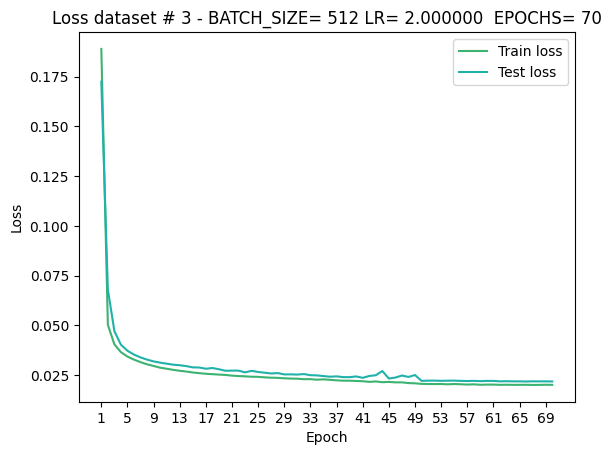

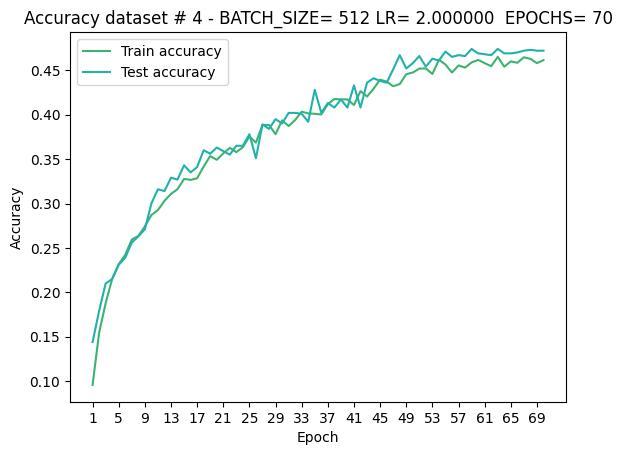

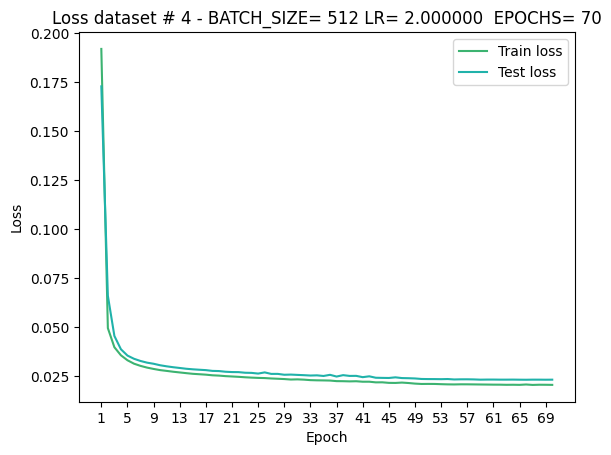

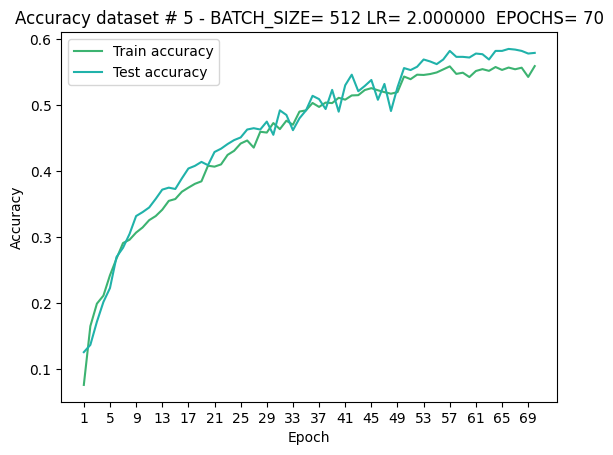

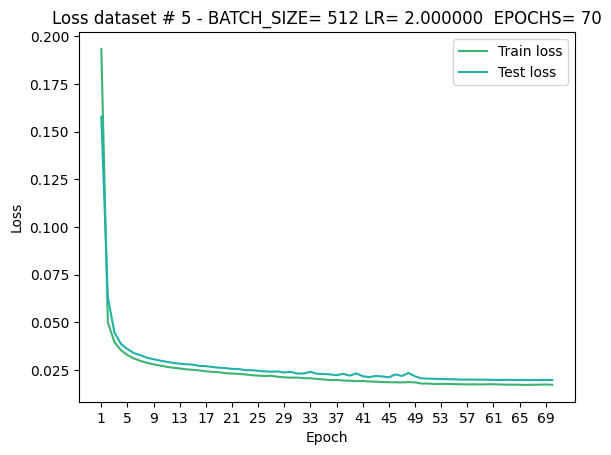

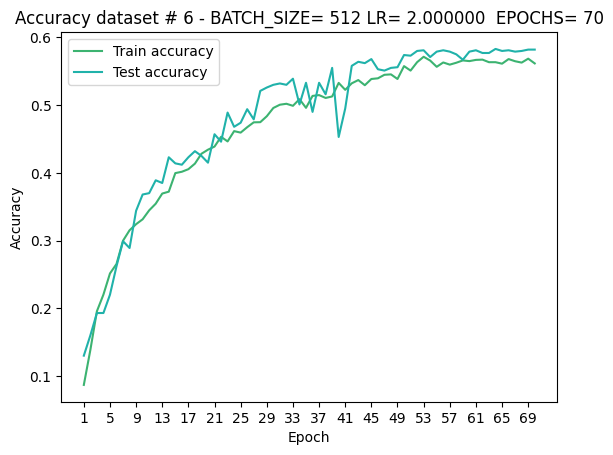

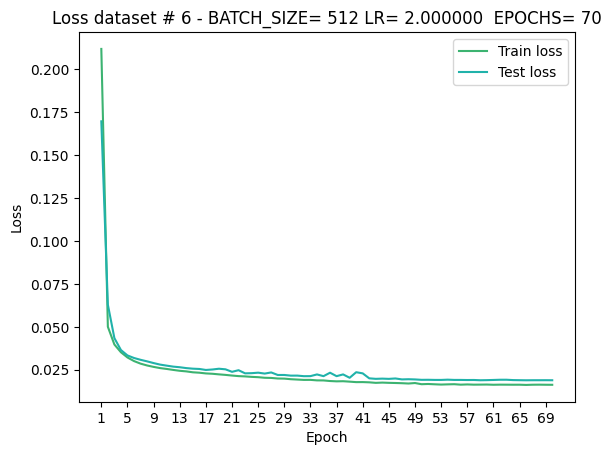

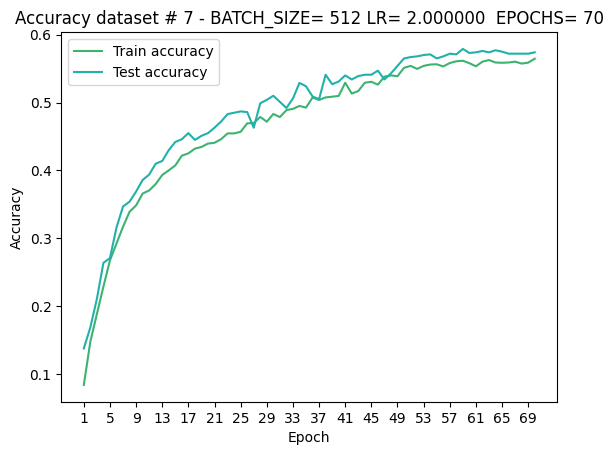

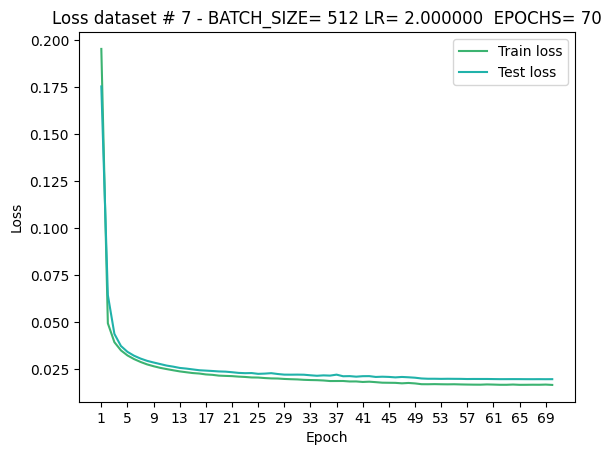

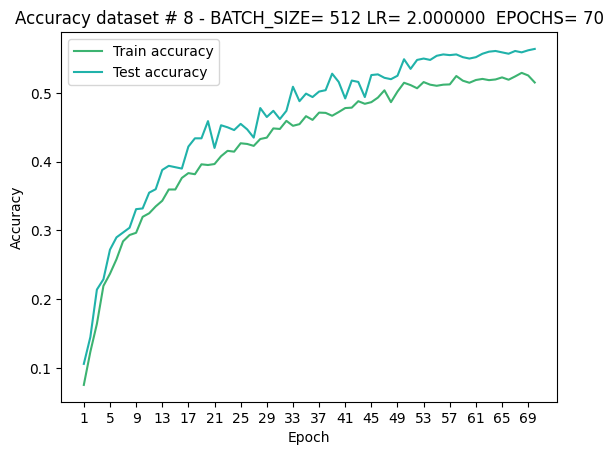

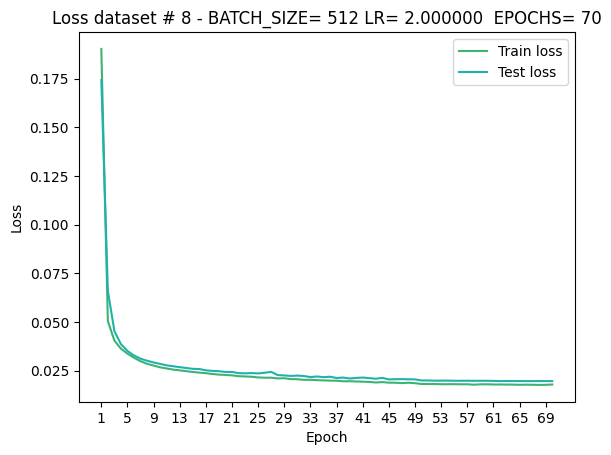

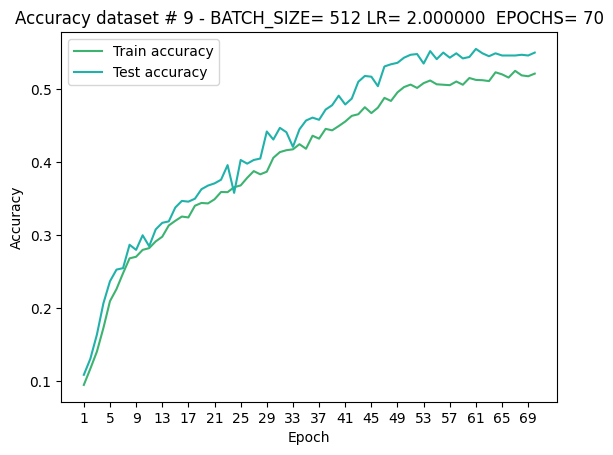

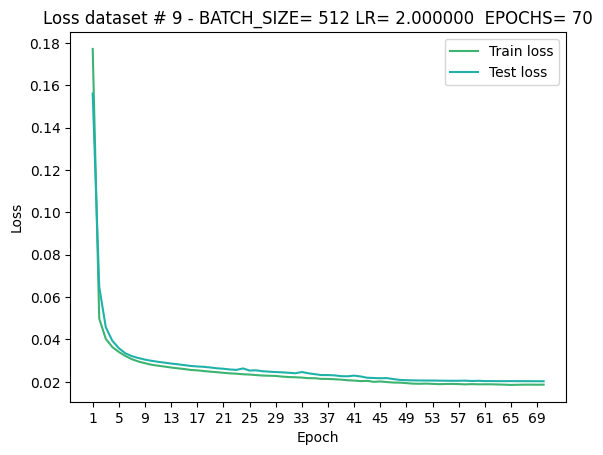

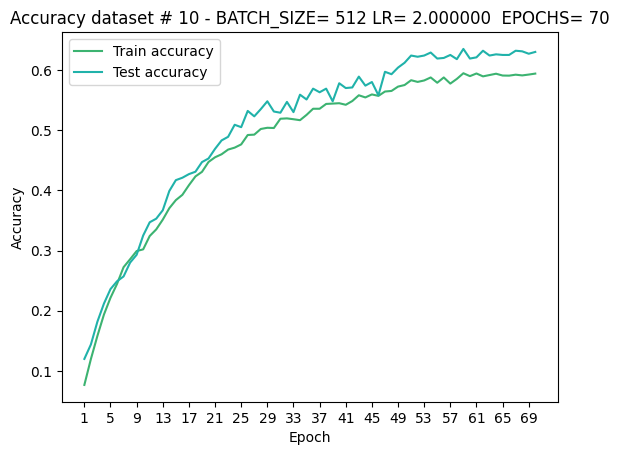

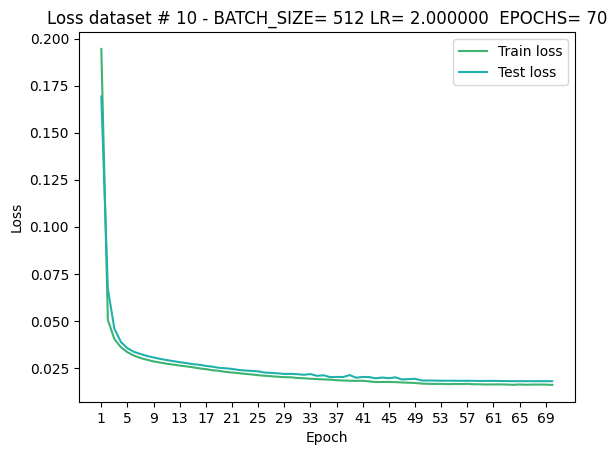

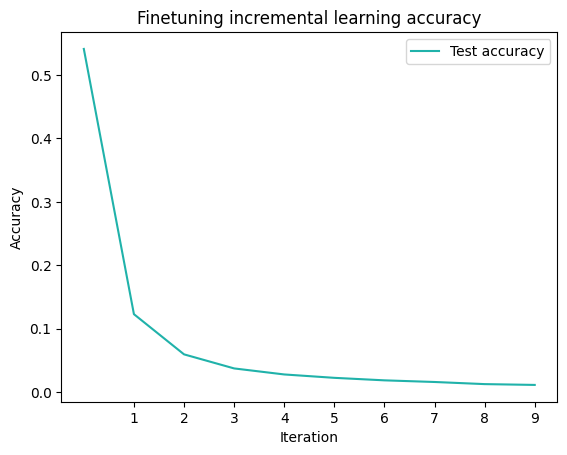

Accuracy last test [0.12, 0.144, 0.182, 0.212, 0.236, 0.249, 0.257, 0.28, 0.293, 0.325, 0.347, 0.353, 0.367, 0.399, 0.417, 0.421, 0.427, 0.431, 0.447, 0.453, 0.469, 0.483, 0.489, 0.509, 0.505, 0.532, 0.523, 0.535, 0.548, 0.531, 0.529, 0.547, 0.53, 0.559, 0.551, 0.569, 0.563, 0.569, 0.548, 0.578, 0.57, 0.571, 0.589, 0.574, 0.58, 0.558, 0.597, 0.593, 0.604, 0.612, 0.624, 0.622, 0.624, 0.629, 0.619, 0.62, 0.625, 0.618, 0.635, 0.619, 0.621, 0.632, 0.624, 0.626, 0.625, 0.625, 0.632, 0.631, 0.627, 0.63]
0.0115


In [ ]:
import numpy as np
plot(new_acc_train_list, new_acc_test_list, new_loss_train_list, new_loss_test_list, np.asarray(all_acc_list)[:, 0], parameters)
print(np.asarray(all_acc_list)[-1, 0])

## Preprocess

In [ ]:
import os

In [ ]:
train_dir = os.path.join(data_dir, 'train') 
valid_dir = os.path.join(data_dir, 'val')

In [ ]:
# show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
# show batch on an image
def show_batch(dataloader):
    dataiter = iter(dataloader)
    images, labels = dataiter.next()    
    imshow(make_grid(images)) # Using Torchvision.utils make_grid function

In [ ]:
# show a single of an image
def show_image(dataloader):
    dataiter = iter(dataloader)
    images, labels = dataiter.next()
    random_num = randint(0, len(images)-1)
    imshow(images[random_num])
    label = labels[random_num]
    print(f'Label: {label}, Shape: {images[random_num].shape}')

In [ ]:
def generate_dataloader(data, name, transform):
    if data is None: 
        return None
    if transform is None:
        dataset = datasets.ImageFolder(data, transform=T.ToTensor())
    else:
        dataset = datasets.ImageFolder(data, transform=transform)

    # Set options for device
    if use_cuda:
        kwargs = {"pin_memory": True, "num_workers": 1}
    else:
        kwargs = {}
    
    # Wrap image dataset (defined above) in dataloader 
    dataloader = DataLoader(dataset, batch_size=batch_size,  shuffle=(name=="train"), **kwargs)
    
    return dataloader

In [ ]:
# Create separate validation subfolders for the validation images based on
# their labels indicated in the val_annotations txt file
val_img_dir = os.path.join(valid_dir, 'images')

# Open and read val annotations text file
fp = open(os.path.join(valid_dir, 'val_annotations.txt'), 'r')
data = fp.readlines()

# Create dictionary to store img filename (word 0) and corresponding
# label (word 1) for every line in the txt file (as key value pair)
val_img_dict = {}
for line in data:
    words = line.split('\t')
    val_img_dict[words[0]] = words[1]
fp.close()

# Display first 10 entries of resulting val_img_dict dictionary
{k: val_img_dict[k] for k in list(val_img_dict)[:10]}

In [ ]:
# Create subfolders (if not present) for validation images based on label,
# and move images into the respective folders
for img, folder in val_img_dict.items():
    newpath = (os.path.join(val_img_dir, folder))
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    if os.path.exists(os.path.join(val_img_dir, img)):
        os.rename(os.path.join(val_img_dir, img), os.path.join(newpath, img))

In [ ]:
# Define transformation sequence for image pre-processing
# If not using pre-trained model, normalize with 0.5, 0.5, 0.5 (mean and SD)
# If using pre-trained ImageNet, normalize with mean=[0.485, 0.456, 0.406], 
# std=[0.229, 0.224, 0.225])

preprocess_transform_pretrain = T.Compose([
                T.Resize((224, 224)),
                T.ToTensor(),  # Converting cropped images to tensors
                T.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225])])

In [ ]:
# Define batch size for DataLoaders
batch_size = 64
# Create DataLoaders for pre-trained models (normalized based on specific requirements)
train_loader = generate_dataloader(train_dir, "train",
                                  transform=preprocess_transform_pretrain)

val_loader= generate_dataloader(val_img_dir, "val",
                                 transform=preprocess_transform_pretrain)

In [ ]:
temp = next(iter(val_loader))

In [ ]:
temp[1]

In [ ]:
temp[0][0].shape

PyTorch only caches the gradients of the leaf nodes in the computational graph, such as weights, biases and other parameters. The gradients of the output with respect to the activations are merely intermediate values and are discarded as soon as the gradient propagates through them on the way back.

We can use hooks to extract intermediate values and pull the gradients out of the model. The hook will be called every time a gradient with respect to the Tensor is computed.



## Model

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torchvision.models import vgg16
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
model = vgg16(pretrained=True)
in_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(in_features, 200)
model.eval()

In [ ]:
for images, labels in val_loader:
        prediction = model(images)
        _, predicted_class = torch.max(prediction, 1)